# **SpaceX  Falcon 9 First Stage Landing Prediction**

**Project Background and Context:**

This project aims to predict the successful landing of the Falcon 9 first stage. SpaceX offers
Falcon 9 rocket launches at a significantly lower cost compared to other providers, mainly due to the
reusability of the first stage. Determining the success of the first stage landing is crucial for estimating
the overall launch cost accurately.

SpaceX has gained worldwide attention for a series of historic milestones. 

It is the only private company ever to return a spacecraft from low-earth orbit, which it first accomplished in December 2010.
SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars wheras other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. 


Therefore if we can determine if the first stage will land, we can determine the cost of a launch. 

This information can be used if an alternate company wants to bid against SpaceX for a rocket launch.

**Problems I want to find answers to:**

This project seeks to address the challenge of predicting whether the Falcon 9 first stage will land
successfully. This prediction is essential for companies considering bidding against SpaceX for rocket
launch contracts, as it directly influences the cost estimation and competitiveness in the commercial
space launch market.

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/landing_1.gif)

### Summary:

1. **Data Collection:**
    * Data scraped and reformatted from the SpaceX API
2. **Data Wrangling:**
    * EDA to find patterns and conversion of the outcomes into training labels
3. **Exploratory Data Analysis (EDA) with visualization and SQL**

4. **Interactive visual analytics with Folium and Plotly Dash**

5. **Predictive analysis using classification models**
    * How to build, tune and evaluate classification models


In [63]:
# Importing the libraries
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sqlalchemy
import sqlite3
import folium
import wget
import cv2
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## 1. Data Collection:

In [2]:
# Defining auxiliary functions

# From the rocket column, we want to learn the booster name
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])


# From the launchpad, we want to know the name of the launch site being used and its coordinates
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])


# From the payload, we want to know the mass of the payload and the orbit it is going to
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])


# From cores, we would like to learn the outcome of the landing, the type of the landing, number of flights 
# with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing 
# pad used, the block of the core which is a number used to seperate version of cores, the number of times 
# this specific core has been reused, and the serial of the core.

# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

Now let's start requesting rocket launch data from SpaceX API with the following URL:

In [3]:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)

In [4]:
# Request and parse the SpaceX launch data
# To make the requested JSON results more consistent, we will use the following static response object:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

# If response code = 200, the request was successful:
response.status_code

200

In [5]:
# Use json_normalize meethod to convert the json result into a dataframe
json_data = response.json()
data = pd.json_normalize(json_data)

# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

The data from these requests will be stored in lists and will be used to create a new dataframe:

In [6]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [7]:
# Call getBoosterVersion
getBoosterVersion(data)
# Call getLaunchSite
getLaunchSite(data)
# Call getPayloadData
getPayloadData(data)
# Call getCoreData
getCoreData(data)

In [8]:
# Constructing the dataset combining the columns into a dictionary:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

# Creating a dataframe from launch_dict
data = pd.DataFrame(launch_dict)

Next, we'll filter the dataframe to include only `Falcon 9` launches:

In [9]:
df9 = data[data['BoosterVersion'] == 'Falcon 9']

# Create a copy of the DataFrame
df9 = df9.copy()

# Assign FlightNumber using the copy
df9['FlightNumber'] = list(range(1, df9.shape[0] + 1))

# Reset FlightNumber column
df9.loc[:, 'FlightNumber'] = list(range(1, df9.shape[0]+1))

## 2. Data Wrangling:

We will perform some Exploratory Data Analysis (EDA) to find some patterns in the data and determine what would be the label for training supervised models. 

In the dataset, there are several different cases where the booster did not land successfully. Sometimes a landing was attempted but failed due to an accident; for example, <code>True Ocean</code> means the mission outcome was successfully  landed to a specific region of the ocean while <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean. <code>True RTLS</code> means the mission outcome was successfully  landed to a ground pad <code>False RTLS</code> means the mission outcome was unsuccessfully landed to a ground pad.<code>True ASDS</code> means the mission outcome was successfully landed on  a drone ship <code>False ASDS</code> means the mission outcome was unsuccessfully landed on a drone ship. 

We will mainly convert those outcomes into Training Labels with `1` means the booster successfully landed `0` means it was unsuccessful.

In [10]:
# Identify which columns are numerical and categorical
df9.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

We'll deal with the missing values in the dataset:

In [11]:
# Checking for missing values
df9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

Before we can continue we must deal with these missing values. The <code>LandingPad</code> column will retain None values to represent when landing pads were not used.

In [12]:
# Calculating the mean for the PayloadMass and using it to replace NaN values in the data
payload_mass_mean = df9['PayloadMass'].mean()
df9['PayloadMass'].replace(np.nan, payload_mass_mean, inplace=True)
df9.isnull().sum()

C:\Users\zoedu\AppData\Local\Temp\ipykernel_24136\2588083926.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df9['PayloadMass'].replace(np.nan, payload_mass_mean, inplace=True)


FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [13]:
df9.to_csv('dataset_part_1.csv', index=False)

The data contains several Space X  launch facilities: <a href='https://en.wikipedia.org/wiki/List_of_Cape_Canaveral_and_Merritt_Island_launch_sites'>Cape Canaveral Space</a> Launch Complex 40  <b>VAFB SLC 4E </b> , Vandenberg Air Force Base Space Launch Complex 4E <b>(SLC-4E)</b>, Kennedy Space Center Launch Complex 39A <b>KSC LC 39A </b>.

In [14]:
# Count the number of launches on each site
df9['LaunchSite'].value_counts()

LaunchSite
CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: count, dtype: int64

Each launch aims to an dedicated orbit, and here are some common orbit types:

* <b>LEO</b>: Low Earth orbit (LEO)is an Earth-centred orbit with an altitude of 2,000 km (1,200 mi) or less (approximately one-third of the radius of Earth),[1] or with at least 11.25 periods per day (an orbital period of 128 minutes or less) and an eccentricity less than 0.25.[2] Most of the manmade objects in outer space are in LEO <a href='https://en.wikipedia.org/wiki/Low_Earth_orbit'>[1]</a>.

* <b>VLEO</b>: Very Low Earth Orbits (VLEO) can be defined as the orbits with a mean altitude below 450 km. Operating in these orbits can provide a number of benefits to Earth observation spacecraft as the spacecraft operates closer to the observation<a href='https://www.researchgate.net/publication/271499606_Very_Low_Earth_Orbit_mission_concepts_for_Earth_Observation_Benefits_and_challenges'>[2]</a>.


* <b>GTO</b> A geosynchronous orbit is a high Earth orbit that allows satellites to match Earth's rotation. Located at 22,236 miles (35,786 kilometers) above Earth's equator, this position is a valuable spot for monitoring weather, communications and surveillance. Because the satellite orbits at the same speed that the Earth is turning, the satellite seems to stay in place over a single longitude, though it may drift north to south,” NASA wrote on its Earth Observatory website <a  href="https://www.space.com/29222-geosynchronous-orbit.html" >[3] </a>.


* <b>SSO (or SO)</b>: It is a Sun-synchronous orbit  also called a heliosynchronous orbit is a nearly polar orbit around a planet, in which the satellite passes over any given point of the planet's surface at the same local mean solar time <a href="https://en.wikipedia.org/wiki/Sun-synchronous_orbit">[4] </a>.
    
    
    
* <b>ES-L1 </b>:At the Lagrange points the gravitational forces of the two large bodies cancel out in such a way that a small object placed in orbit there is in equilibrium relative to the center of mass of the large bodies. L1 is one such point between the sun and the earth <a href="https://en.wikipedia.org/wiki/Lagrange_point#L1_point">[5]</a> .
    
    
* <b>HEO</b> A highly elliptical orbit, is an elliptic orbit with high eccentricity, usually referring to one around Earth <a href="https://en.wikipedia.org/wiki/Highly_elliptical_orbit">[6]</a>.


* <b> ISS </b> A modular space station (habitable artificial satellite) in low Earth orbit. It is a multinational collaborative project between five participating space agencies: NASA (United States), Roscosmos (Russia), JAXA (Japan), ESA (Europe), and CSA (Canada)<a href="https://en.wikipedia.org/wiki/International_Space_Station"> [7] </a>


* <b> MEO </b> Geocentric orbits ranging in altitude from 2,000 km (1,200 mi) to just below geosynchronous orbit at 35,786 kilometers (22,236 mi). Also known as an intermediate circular orbit. These are "most commonly at 20,200 kilometers (12,600 mi), or 20,650 kilometers (12,830 mi), with an orbital period of 12 hours <a href="https://en.wikipedia.org/wiki/List_of_orbits"> [8] </a>


* <b> HEO </b> Geocentric orbits above the altitude of geosynchronous orbit (35,786 km or 22,236 mi) <a href="https://en.wikipedia.org/wiki/List_of_orbits"> [9] </a>


* <b> GEO </b> It is a circular geosynchronous orbit 35,786 kilometres (22,236 miles) above Earth's equator and following the direction of Earth's rotation <a href="https://en.wikipedia.org/wiki/Geostationary_orbit"> [10] </a>


* <b> PO </b> It is one type of satellites in which a satellite passes above or nearly above both poles of the body being orbited (usually a planet such as the Earth <a href="https://en.wikipedia.org/wiki/Polar_orbit"> [11] </a>

Some are shown in the following plot:

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/Orbits.png)

In [15]:
# Counting the number and occurence of each orbit
df9['Orbit'].value_counts()

Orbit
GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: count, dtype: int64

In [16]:
# Counting the number and occurence of landing_outcomes and assign it to variable landing_outcomes
landing_outcomes = df9['Outcome'].value_counts()

<code>True Ocean</code> means the mission outcome was successfully  landed to a specific region of the ocean while <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean. <code>True RTLS</code> means the mission outcome was successfully  landed to a ground pad <code>False RTLS</code> means the mission outcome was unsuccessfully landed to a ground pad.<code>True ASDS</code> means the mission outcome was successfully  landed to a drone ship <code>False ASDS</code> means the mission outcome was unsuccessfully landed to a drone ship. <code>None ASDS</code> and <code>None None</code> these represent a failure to land.


In [17]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [18]:
# Create a set of outcomes where the second stage did not land successfully
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])

Using the <code>Outcome</code>,  create a list where the element is zero if the corresponding  row  in  <code>Outcome</code> is in the set <code>bad_outcome</code>; otherwise, it's one. Then assign it to the variable <code>landing_class</code>:

In [19]:
# landing_class = 0 if bad_outcome
# landing_class = 1 otherwise

df9['Landing_Class'] = [0 if outcome in bad_outcomes else 1 for outcome in df9['Outcome']]
landing_class = df9['Landing_Class'].tolist()

We can then determine the success rate:

In [20]:
df9["Landing_Class"].mean()

0.6666666666666666

In [21]:
df9.to_csv("dataset_part_2.csv", index=False)

## 3. EDA using visualization and SQL:

### 3.1: Visualization

First, let's try to see how the `FlightNumber` (indicating the continuous launch attempts.) and `Payload` variables would affect the launch outcome.

We can plot out the <code>FlightNumber</code> vs. <code>PayloadMass</code>and overlay the outcome of the launch. We see that as the flight number increases, the first stage is more likely to land successfully. The payload mass is also important; it seems the more massive the payload, the less likely the first stage will return.

c:\Users\zoedu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


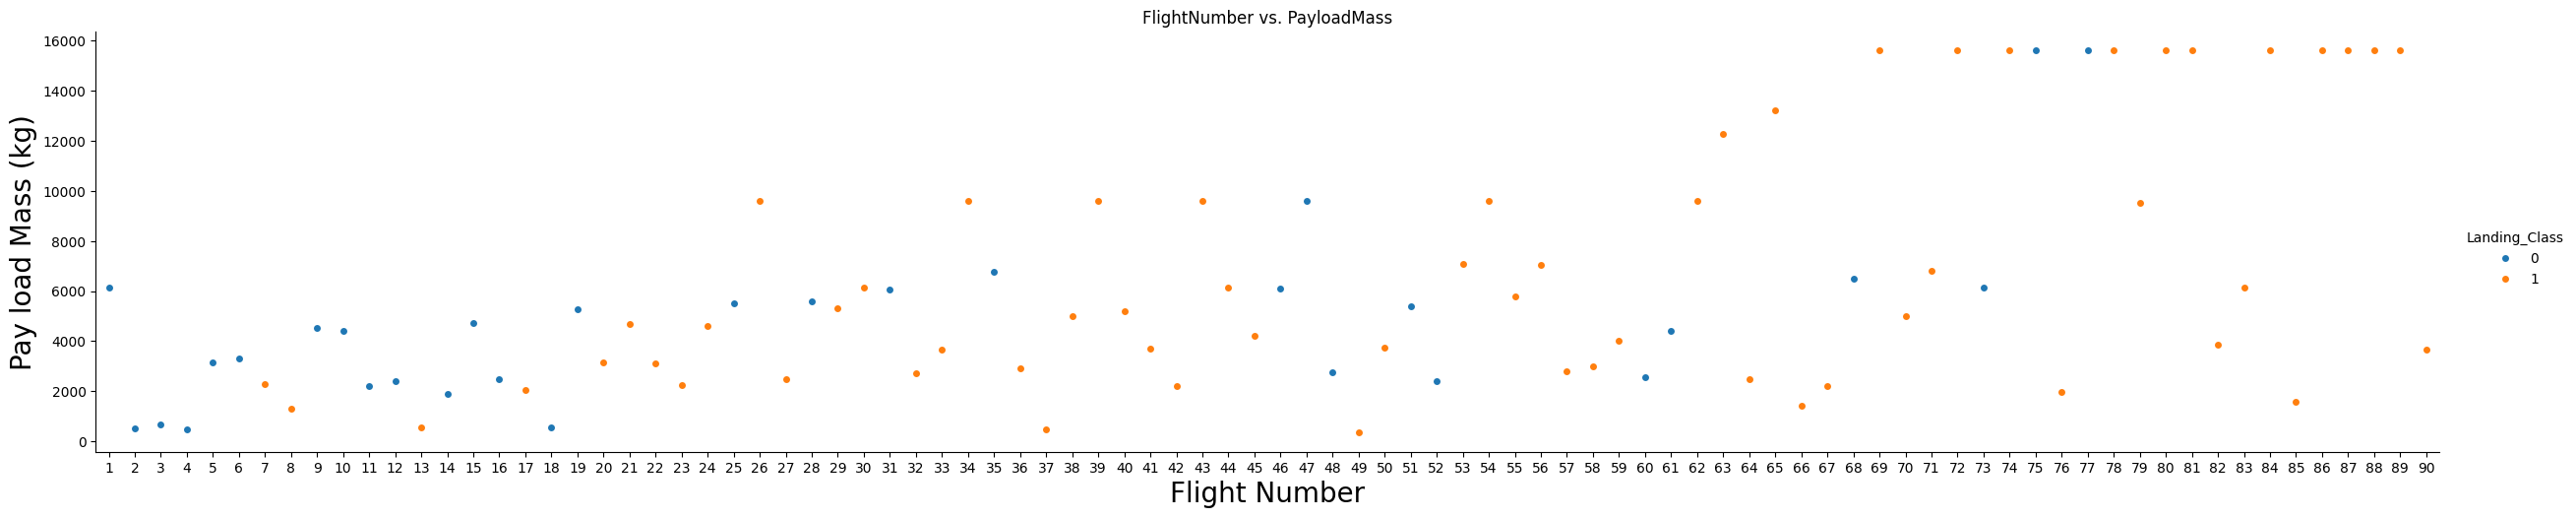

In [22]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Landing_Class", data=df9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.title('FlightNumber vs. PayloadMass')
plt.show()

We see that different launch sites have different success rates.  <code>CCAFS LC-40</code>, has a success rate of 60 %, while  <code>KSC LC-39A</code> and <code>VAFB SLC 4E</code> has a success rate of 77%.

c:\Users\zoedu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


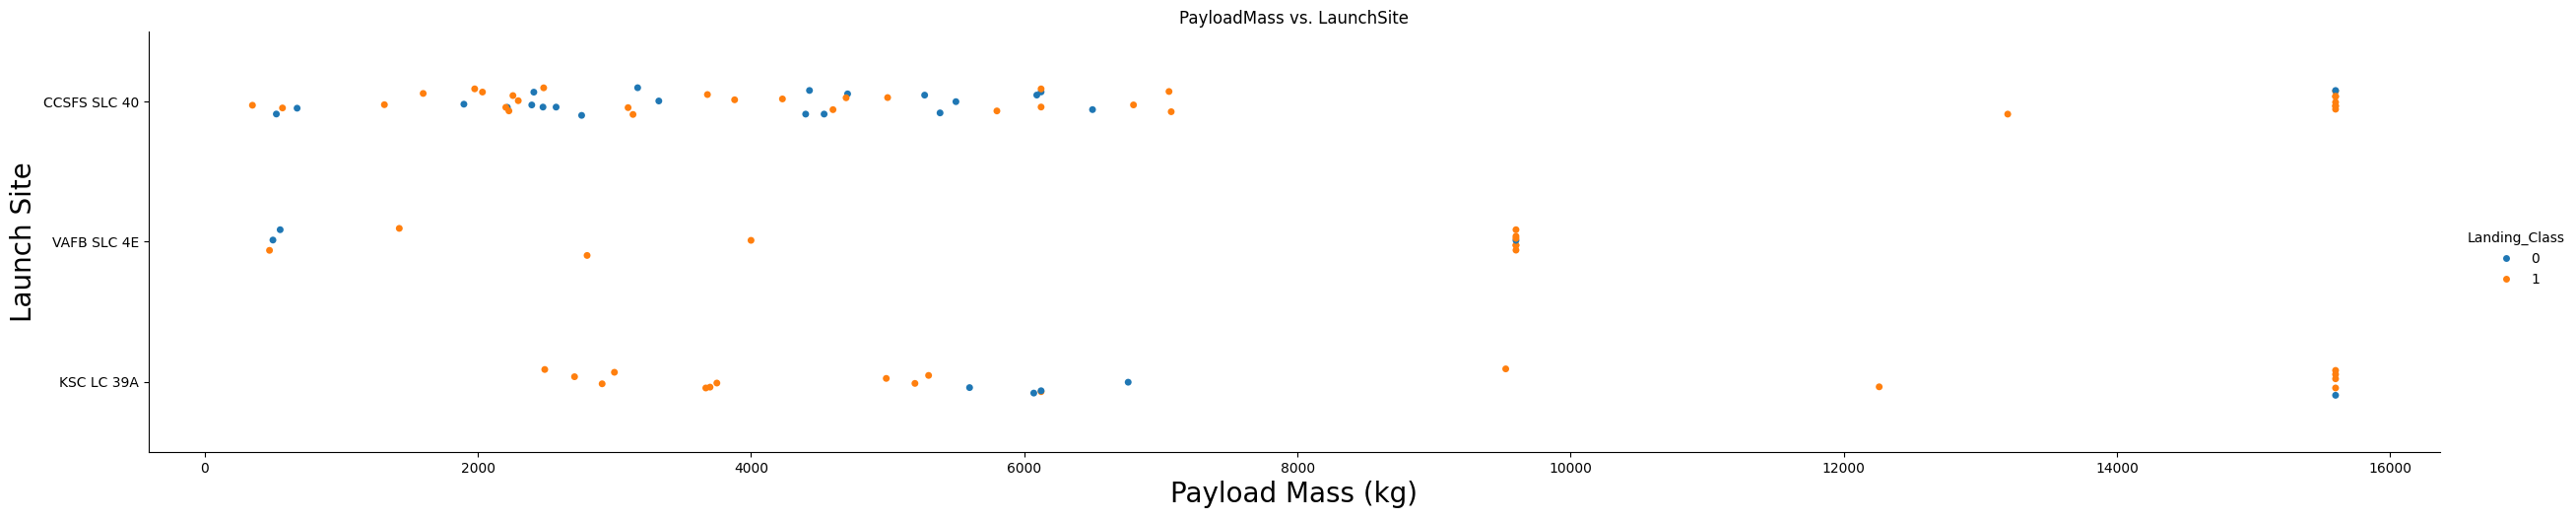

In [23]:
# Visualize the relationship between Payload and LaunchSite
sns.catplot(y='LaunchSite', x='PayloadMass', hue='Landing_Class', data=df9, aspect=5)
plt.xlabel("Payload Mass (kg)",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.title('PayloadMass vs. LaunchSite')
plt.show()

We find that for the <code> VAFB-SLC</code> launchsite there are no rockets launched for heavypayload mass (greater than 10000).

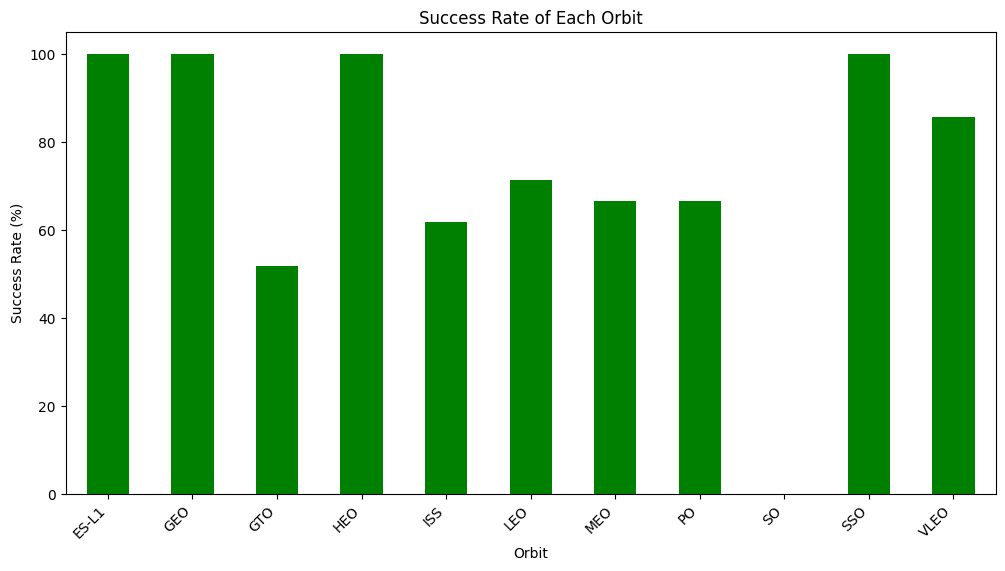

In [24]:
# Visualize the relationship between the success rate of each orbit type
orbit_success_rate = df9.groupby('Orbit')['Landing_Class'].mean()
orbit_success_rate_percentage = orbit_success_rate.multiply(100) #percentage

plt.figure(figsize=(12, 6))
orbit_success_rate_percentage.plot(kind='bar', color='green')
plt.title('Success Rate of Each Orbit')
plt.xlabel('Orbit')
plt.ylabel('Success Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.show()

The highest success rates are close to 100% for the orbits: ES-L1, GEO, HEO and SSO.

c:\Users\zoedu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


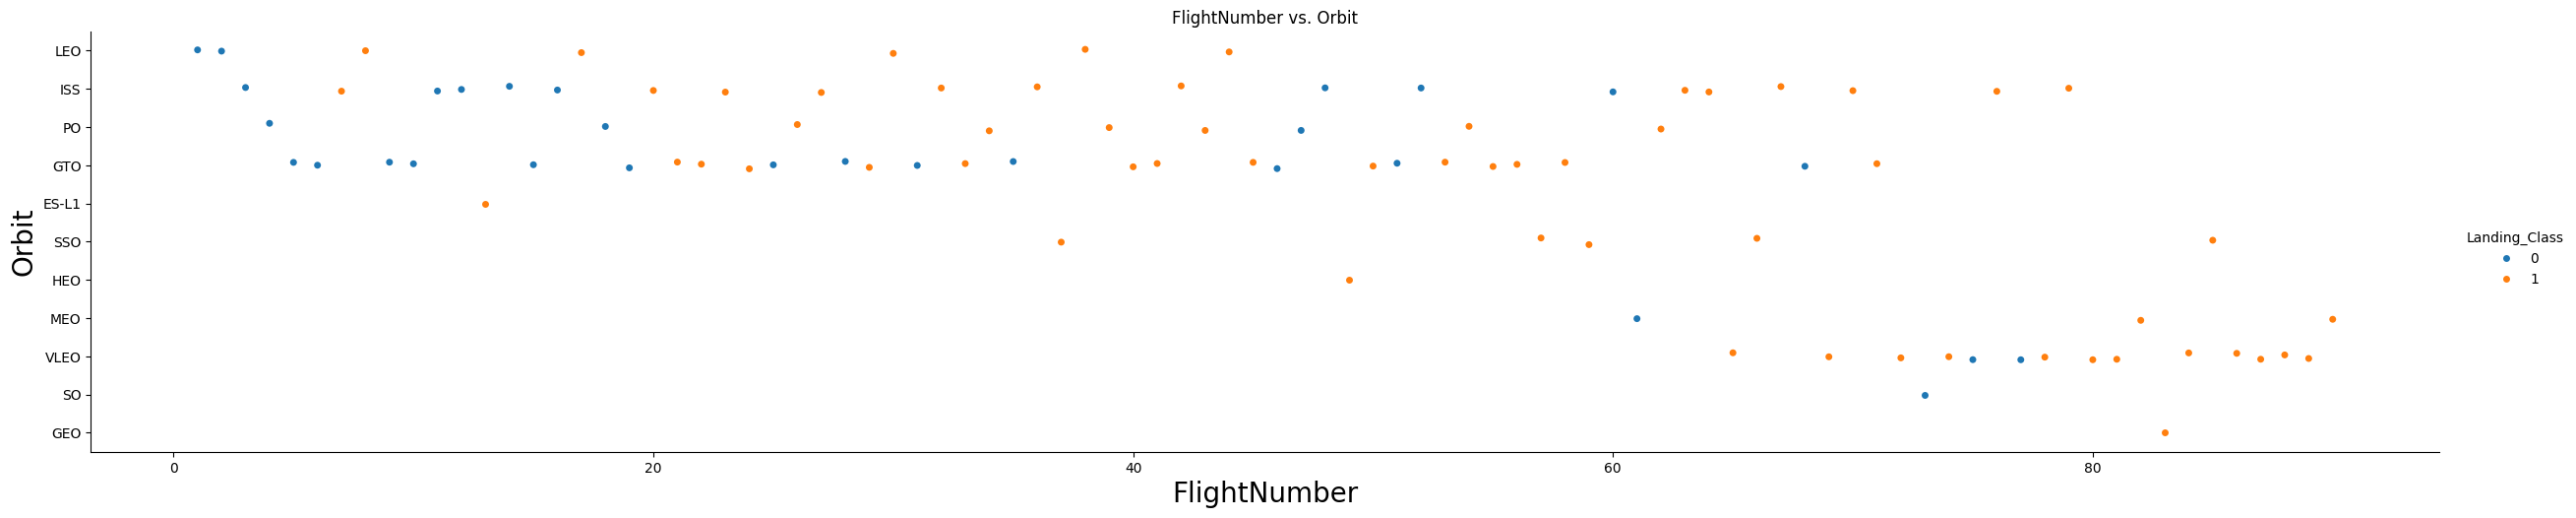

In [25]:
# Visualize the relationship between FlightNumber and Orbit
sns.catplot(y='Orbit', x='FlightNumber', hue='Landing_Class', data=df9, aspect=5)
plt.xlabel("FlightNumber",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.title('FlightNumber vs. Orbit')
plt.show()

We can see that in the LEO orbit the Success appears related to the number of flights, on the other hand, there seems to be no relationship between flight number when in GTO orbit.


c:\Users\zoedu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


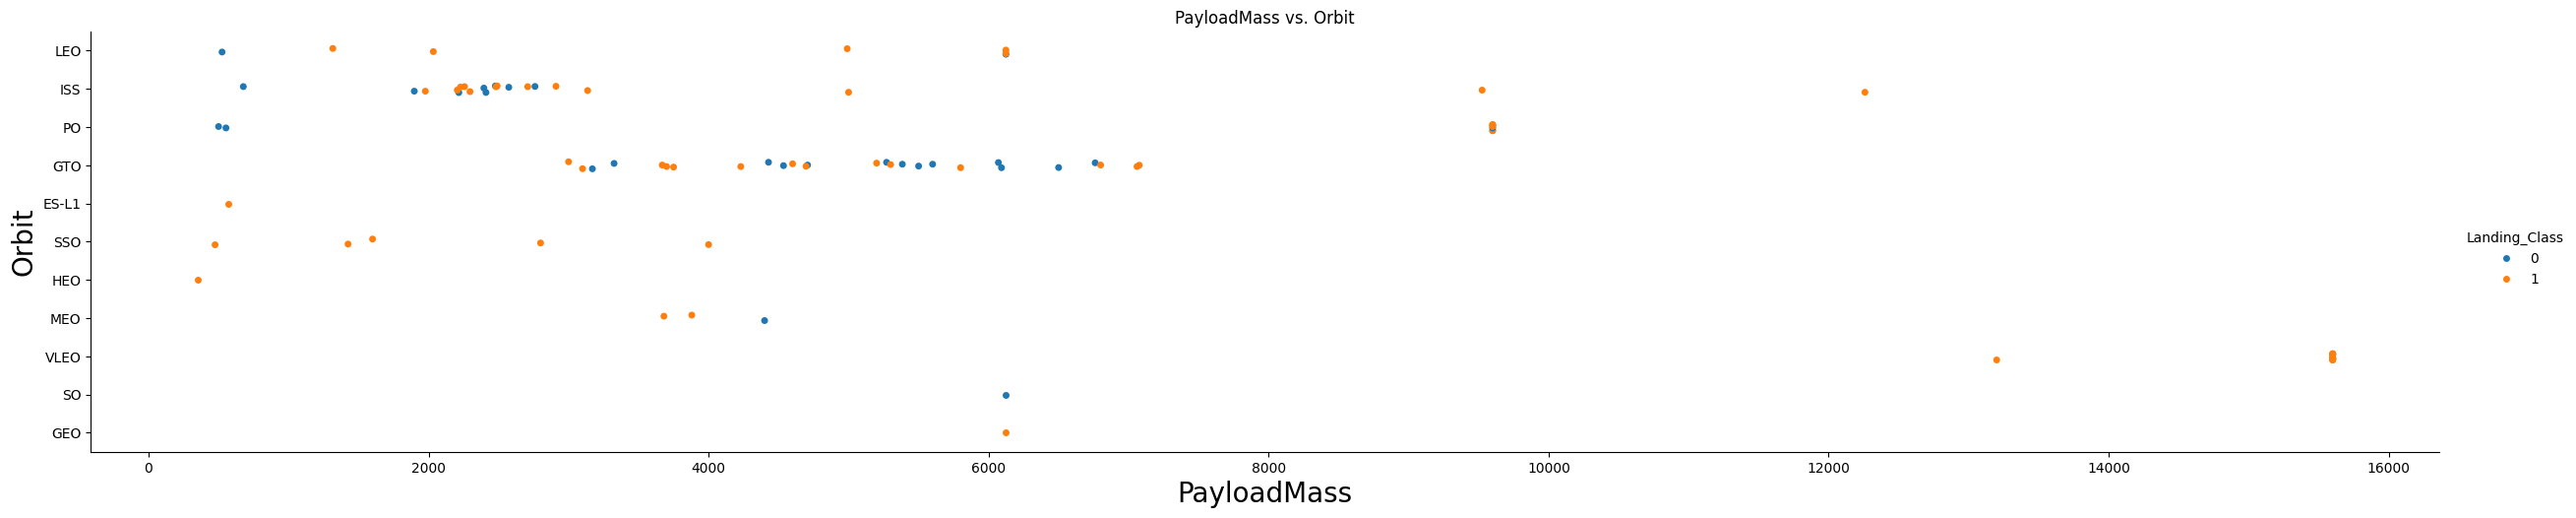

In [26]:
# Visualize the relationship between Payload and Orbit
sns.catplot(y='Orbit', x='PayloadMass', hue='Landing_Class', data=df9, aspect=5)
plt.xlabel("PayloadMass",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.title('PayloadMass vs. Orbit')
plt.show()

With heavy payloads the successful landing or positive landing rate are more for Polar, LEO and ISS.   

However for GTO we cannot distinguish this well as both positive landing rate and negative landing(unsuccessful mission) are both there here.

In [27]:
df9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Landing_Class
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


In [28]:
# Visualize the launch success yearly trend
# Function to extract years from the date 
def Extract_year(date):
    for i in date:
        year.append(i.year)
    return year

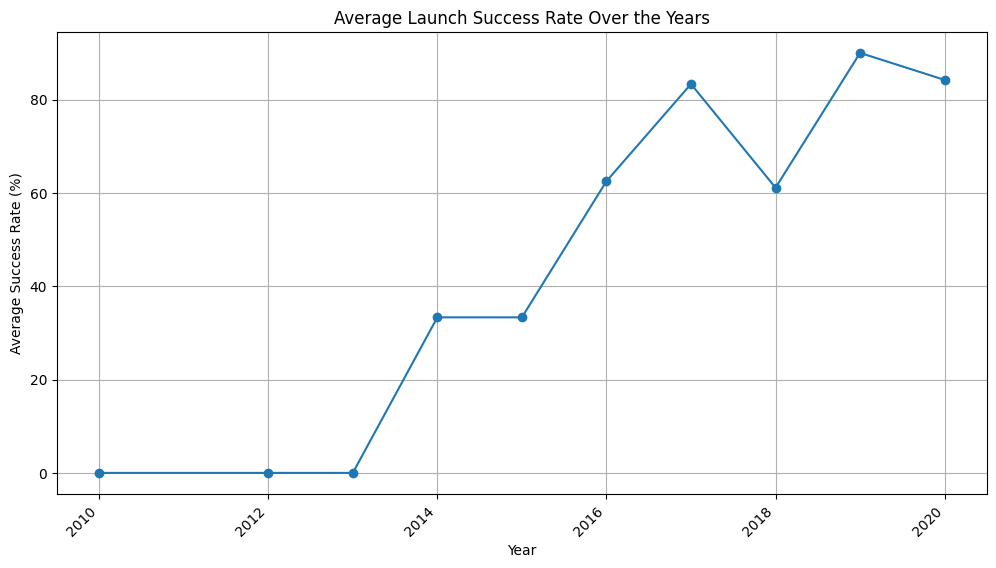

In [29]:
year=[]
df9['Year'] = Extract_year(df9['Date'])

average_success_rate_per_year = df9.groupby('Year')['Landing_Class'].mean()
average_success_rate_per_year_percentage = average_success_rate_per_year.multiply(100) #percentage

plt.figure(figsize=(12, 6))
plt.plot(average_success_rate_per_year_percentage.index, average_success_rate_per_year_percentage, marker='o', linestyle='-')
plt.title('Average Launch Success Rate Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Success Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

We can observe that the success rate since 2013 kept increasing until 2017 (stable in 2014), decreased in 2018, and increased back after.


#### Features Engineering:

In [30]:
features = df9[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]

# Create dummy variables to categorical columns
columns_to_encode = ['Orbit', 'LaunchSite', 'LandingPad', 'Serial']
features_one_hot = pd.get_dummies(features, columns=columns_to_encode)

# Cast the entire dataframe to float64
features_one_hot = features_one_hot.astype('float64')

### 3.2: SQL

## 4. Interactive visual analytics with Folium and Plotly Dash


### 4.1: Folium

In [31]:
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

In [32]:
# Download and read the `spacex_launch_geo.csv`
spacex_csv_file = wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv')
spacex_df=pd.read_csv(spacex_csv_file)

In [33]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


We first need to create a folium `Map` object, with an initial center location to be NASA Johnson Space Center at Houston, Texas. Then, we'll highlight every launch site on the map.


In [34]:
# Start location is NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

Now, let's add a circle for each launch site in data frame `launch_sites`


In [35]:
# Initial the map
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label

# Iterate through each row in launch_sites_df
for index, row in launch_sites_df.iterrows():
    # Get the coordinates of the launch site
    site_coordinate = [row['Lat'], row['Long']]

    # Create a circle for the launch site
    circle = folium.Circle(site_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup(row['Launch Site']))

    # Create a marker for the launch site with an icon and popup label
    marker = folium.map.Marker(
        site_coordinate,
        icon=DivIcon(
            icon_size=(20, 20),
            icon_anchor=(0, 0),
            html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % row['Launch Site'],
        )
    )
    
    # Add the circle and marker to the site map
    site_map.add_child(circle)
    site_map.add_child(marker)

site_map

We notice that all launch sites are in proximity to the Equator line and in very close proximity to the coast. 
Rocket launch sites are primarily located near the equator and coasts for two key reasons. Firstly, Earth's rotation at the equator gives rockets a natural eastward boost, reducing fuel needs. Secondly, coastal locations offer a safety zone over the ocean in case of launch failures and easier access for transporting rockets and equipment.  This combination of efficiency and safety makes equatorial coastal regions ideal for launching rockets.

Then, we'll mark the successful/failed launches for each site on the map in order to determine the sites with the highest success rates.

In [36]:
marker_cluster = MarkerCluster()

# If class=1, marker_color value will be green
# If class=0, marker_color value will be red

# Function to determine marker color based on class value
def get_marker_color(class_value):
    return 'green' if class_value == 1 else 'red'

# Apply the function to create the 'marker_color' column
launch_sites_df['marker_color'] = spacex_df['class'].apply(get_marker_color)

# Function to assign color to launch outcome
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
    
spacex_df['marker_color'] = spacex_df['class'].apply(assign_marker_color)

In [37]:
# Add marker_cluster to current site_map
site_map.add_child(marker_cluster)

for index, record in spacex_df.iterrows():
    # Coordonnées du marqueur
    marker_location = [record['Lat'], record['Long']]
    
    # Couleur de l'icône basée sur la classe
    icon_color = assign_marker_color(record['class'])
    
    # Créez et ajoutez un marqueur à la carte
    marker = folium.Marker(
        location=marker_location,
        popup=f"Launch Site: {record['Launch Site']}\nOutcome: {record['class']}",
        icon=folium.Icon(color='white', icon_color=icon_color)
    )
    
    marker.add_to(marker_cluster)

site_map

The launch site KSC LC-39A has the highest success rate of around 77%.


Next, we want to explore and analyse the proximities of the launch sites.

Let's first add a `MousePosition` on the map to get coordinate for a mouse over a point on the map. As such, while you are exploring the map, you can easily find the coordinates of any points of interests (such as railway)


In [38]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

Now zoom in to a launch site and explore its proximity to see if you can easily find any railway, highway, coastline, etc. Move your mouse to these points and mark down their coordinates (shown on the top-left) in order to the distance to the launch site.


In [39]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [40]:
vafb_site_info = launch_sites_df.loc[launch_sites_df['Launch Site'] == 'VAFB SLC-4E']

# Sélectionner les colonnes 'Launch Site', 'Lat', 'Long' du résultat
launch_site_lat, launch_site_lon = vafb_site_info.iloc[0][['Lat', 'Long']]


coastline_lat = 34.63469
coastline_lon = -120.62529
distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)
distance_coastline

1.3470246488807776

In [41]:
# Create and add a folium.Marker on your selected closest coastline point on the map
# Display the distance between coastline point and launch site using the icon property 
coordinates_coastline = (coastline_lat, coastline_lon)
coordinates_launchsite = (launch_site_lat, launch_site_lon)

distance_marker = folium.Marker(
   coordinates_coastline,
   icon=DivIcon(
       icon_size=(20,20),
       icon_anchor=(0,0),
       html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_coastline),
       )
   )

In [42]:
# Create a `folium.PolyLine` object using the coastline coordinates and launch site coordinate
coordinates = [coordinates_coastline, coordinates_launchsite]
lines=folium.PolyLine(locations=coordinates, weight=2)
site_map.add_child(lines)
site_map.add_child(distance_marker)

In [43]:
# Create a marker with distance to a closest city, railway, highway, etc.
# Draw a line between the marker to the launch site

city_lat = 34.63843
city_lon = -120.45788
distance_city = calculate_distance(launch_site_lat, launch_site_lon, city_lat, city_lon)

coordinates_city = (city_lat, city_lon)

distance_marker = folium.Marker(
   coordinates_city,
   icon=DivIcon(
       icon_size=(20,20),
       icon_anchor=(0,0),
       html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_city),
       )
   )

coordinates = [coordinates_city, coordinates_launchsite]
lines=folium.PolyLine(locations=coordinates, weight=2)
site_map.add_child(lines)
site_map.add_child(distance_marker)

In [44]:
rail_lat = 34.63586
rail_lon = -120.62396
distance_rail = calculate_distance(launch_site_lat, launch_site_lon, rail_lat, rail_lon)

coordinates_rail = (rail_lat, rail_lon)

distance_marker = folium.Marker(
   coordinates_rail,
   icon=DivIcon(
       icon_size=(20,20),
       icon_anchor=(0,0),
       html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_rail),
       )
   )

coordinates = [coordinates_rail, coordinates_launchsite]
lines=folium.PolyLine(locations=coordinates, weight=2)
site_map.add_child(lines)
site_map.add_child(distance_marker)

Analyzing proximity through distance lines reveals key insights about rocket launch sites. Short lines to railways and highways suggest convenient transportation access for rockets and equipment. Similarly, short lines to coastlines confirm the preference for coastal locations, providing safety zones for potential debris. Conversely, longer lines to major cities indicate strategic placement at a safe distance from populated areas. Overall, this analysis reveals a preference for launch sites near coasts with good transportation access, strategically located away from cities for safety.

### 4.2: Dashboard with Dash

Available in file <code>spacex_dash_app.py</code>

## 5. Predictive analysis using classification models

Perform exploratory  Data Analysis and determine Training Labels

*   Create a column for the class
*   Standardize the data
*   Split into training data and test data

\- Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method that performs best using test data

In [45]:
# Function to plot the confusion matrix
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

In [49]:
data = pd.read_csv('dataset_part_2.csv')
X = pd.read_csv('dataset_part_3.csv')
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Landing_Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [50]:
Y = data['Landing_Class'].to_numpy()
transform = preprocessing.StandardScaler()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

### Logistic Regression:

In [51]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()

# Create GridSearchCV object
logreg_cv = GridSearchCV(lr, parameters, cv=10)

# Fit the GridSearchCV object to find the best parameters
logreg_cv.fit(X_train, Y_train)

c:\Users\zoedu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\zoedu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.

In [52]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.7928571428571428


Calculate the accuracy on the test data using the method <code>score</code>:

In [53]:
accuracy_test = logreg_cv.score(X_test, Y_test)
print("Test accuracy:", accuracy_test)

Test accuracy: 0.8333333333333334


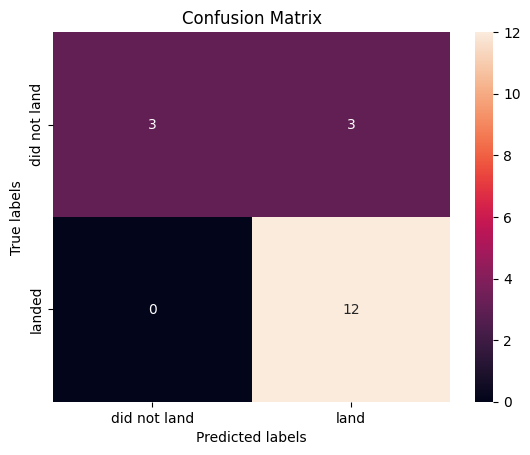

In [54]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


### SVM:

In [74]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

# Create a GridSearchCV object with SVM, parameters, and cross-validation (cv) set to 10
svm_cv = GridSearchCV(svm, parameters, cv=10)

# Fit the GridSearchCV object to find the best parameters
svm_cv.fit(X_train, Y_train)

In [ ]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

Calculate the accuracy on the test data using the method <code>score</code>:

In [ ]:
accuracy_svm = svm_cv.score(X_test, Y_test)
print(accuracy_svm)

In [ ]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### Decision tree:

In [55]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

# Create a GridSearchCV object
tree_cv = GridSearchCV(tree, parameters, cv=10)

# Fit the GridSearchCV object to find the best parameters
tree_cv.fit(X_train, Y_train)

c:\Users\zoedu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\zoedu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\zoedu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\zoedu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [56]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
accuracy : 0.8607142857142858


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:

In [57]:
accuracy_tree = tree_cv.score(X_test, Y_test)
print(accuracy_tree)

0.7777777777777778


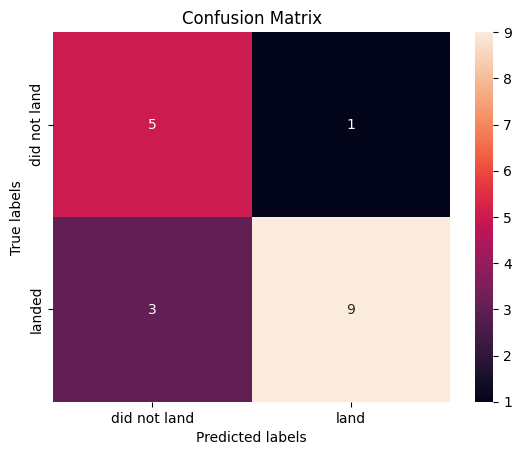

In [58]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### KNN:

In [59]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

# Create a GridSearchCV object
knn_cv = GridSearchCV(KNN, parameters, cv=10)

# Fit the GridSearchCV object to find the best parameters
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [60]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
accuracy : 0.6642857142857143


In [61]:
accuracy_knn = knn_cv.score(X_test, Y_test)
print(accuracy_knn)

0.6111111111111112


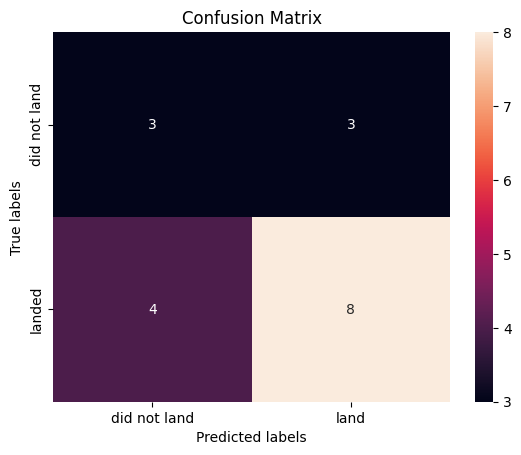

In [62]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### Classification Accuracy: